# Song rank aggregation

Combine cleaned ranking tables, align dates to Mondays, add source/era, and export consolidated CSV.

In [5]:
# 导入库与路径
# Imports and paths
import pandas as pd
from pathlib import Path
import numpy as np


In [6]:
# 读取各表并添加来源标记
# Load tables and add source tags
base_dir = Path('..') / 'output' / 'batch_cleaned'
files = {
    'b100': base_dir / 'billboard100_cleaned.csv',
    'b200': base_dir / 'billboard200_cleaned.csv',
    'digital': base_dir / 'digital_songs_cleaned.csv',
    'radio': base_dir / 'radio_cleaned.csv',
    'stream': base_dir / 'streaming_songs_cleaned.csv',
}

tables = {}
for src, path in files.items():
    df = pd.read_csv(path)
    df['source'] = src
    tables[src] = df
    print(f"Loaded {src}: {df.shape}")


Loaded b100: (353900, 8)
Loaded b200: (639746, 8)
Loaded digital: (52175, 8)
Loaded radio: (91300, 8)
Loaded stream: (33300, 8)


In [7]:
# 日期对齐到周一
# Align dates to Mondays
for src, df in tables.items():
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['date'] = df['date'] - pd.to_timedelta(df['date'].dt.weekday, unit='D')
    tables[src] = df


In [8]:
# 计算 era 边界并合并
# Compute era boundaries and concatenate
radio_min = tables['radio']['date'].min()
digital_min = tables['digital']['date'].min()
stream_min = tables['stream']['date'].min()

print('radio_min:', radio_min)
print('digital_min:', digital_min)
print('stream_min:', stream_min)

full_df = pd.concat(tables.values(), ignore_index=True)

conditions = [
    full_df['date'] < radio_min,
    (full_df['date'] >= radio_min) & (full_df['date'] < digital_min),
    (full_df['date'] >= digital_min) & (full_df['date'] < stream_min),
    full_df['date'] >= stream_min,
]
eras = ['physical', 'radio', 'digital', 'streaming']

full_df['era'] = pd.Series(pd.NA, index=full_df.index)
for cond, era in zip(conditions, eras):
    full_df.loc[cond, 'era'] = era

print(full_df[['source', 'era']].head())
print('Combined shape:', full_df.shape)


radio_min: 1990-10-29 00:00:00
digital_min: 2004-10-25 00:00:00
stream_min: 2013-01-21 00:00:00
  source       era
0   b100  physical
1   b100  physical
2   b100  physical
3   b100  physical
4   b100  physical
Combined shape: (1170421, 9)


In [ ]:
# # 导出合并表
# # Export consolidated table
# out_path = Path('..') / 'output' / 'song_full_rank.csv'
# out_path.parent.mkdir(parents=True, exist_ok=True)
# full_df.to_csv(out_path, index=False)
# print(f'Exported to {out_path}')


Exported to ../output/song_full_rank.csv


## Source-wise top artists/songs by era

Overall Top20 artists and songs (across all eras/sources, filtered)


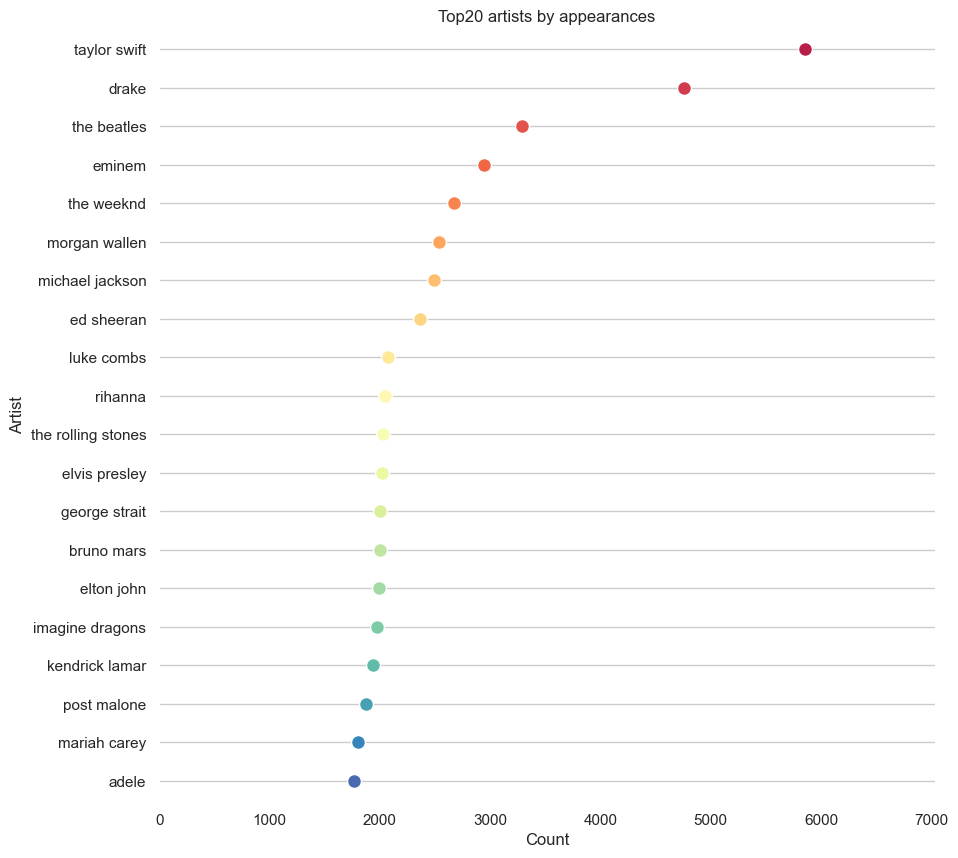

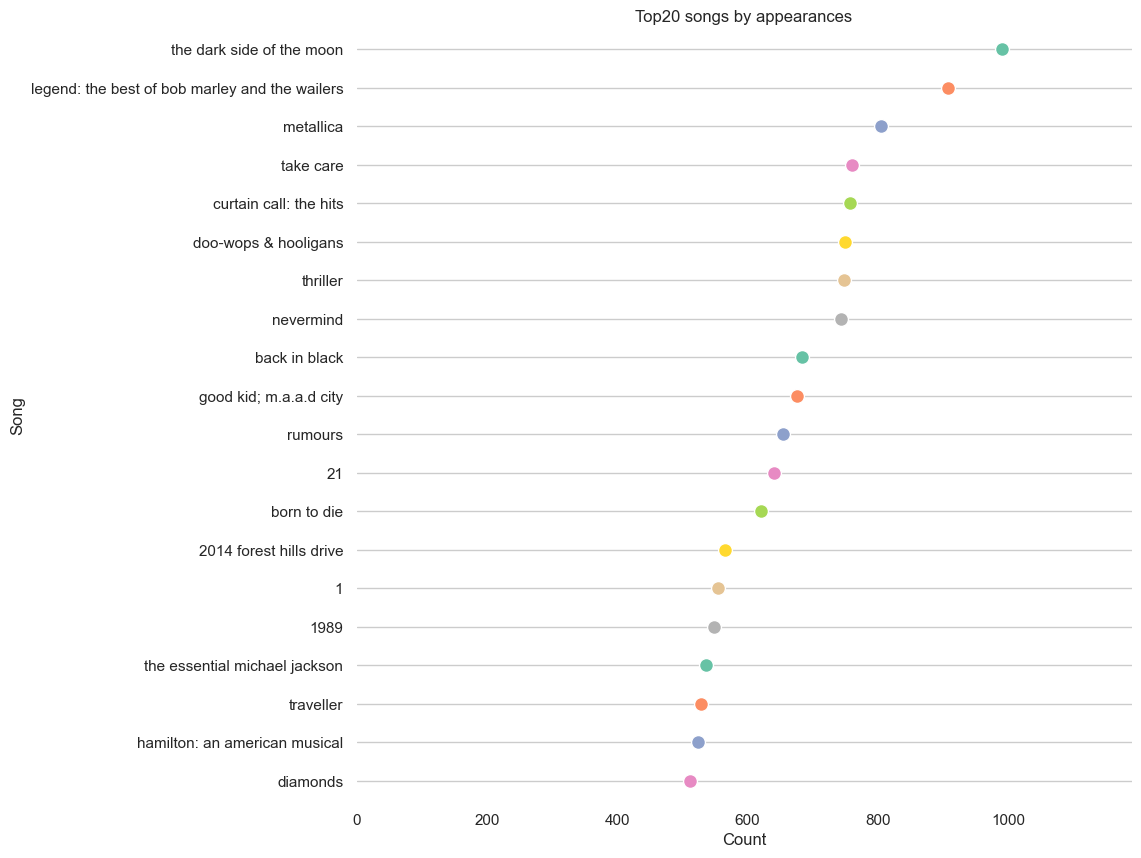

In [54]:
# 跨所有 era/source 的整体 Top20（点图风格），排除 soundtrack/various artists 与含 greatest hits 的歌曲
import seaborn as sns
import matplotlib.pyplot as plt

if 'full_df' not in globals():
    raise NameError('Run previous cells to build full_df')

req_cols = ['artist', 'song']
missing = [c for c in req_cols if c not in full_df.columns]
if missing:
    raise ValueError(f'Missing columns: {missing}')

sns.set_theme(style='whitegrid')

# 过滤不统计的项
mask_artist = full_df['artist'].str.lower().isin(['soundtrack', 'various artists'])
mask_song = full_df['song'].str.lower().str.contains('greatest hits', na=False)
filtered = full_df[~mask_artist & ~mask_song]

# Top20 artists and songs overall
top_artists = filtered['artist'].value_counts().head(20).reset_index()
top_artists.columns = ['artist', 'count']

top_songs = filtered['song'].value_counts().head(20).reset_index()
top_songs.columns = ['song', 'count']

print('Overall Top20 artists and songs (across all eras/sources, filtered)')

# Artists stripplot with per-row colors
if not top_artists.empty:
    order_art = top_artists.sort_values('count', ascending=False)['artist']
    pal_art = sns.color_palette('Spectral', n_colors=len(order_art))
    plt.figure(figsize=(10, 10))
    sns.stripplot(data=top_artists, x='count', y='artist', order=order_art,
                  hue='artist', palette=pal_art, size=10, orient='h', jitter=False,
                  linewidth=1, edgecolor='w', legend=False)
    plt.title('Top20 artists by appearances')
    plt.xlabel('Count')
    plt.ylabel('Artist')
    plt.xlim(0, top_artists['count'].max()*1.2)
    plt.gca().xaxis.grid(False)
    plt.gca().yaxis.grid(True)
    sns.despine(left=True, bottom=True)
    plt.show()
else:
    print('No artist data')

# Songs stripplot with per-row colors
if not top_songs.empty:
    order_song = top_songs.sort_values('count', ascending=False)['song']
    pal_song = sns.color_palette('Set2', n_colors=len(order_song))
    plt.figure(figsize=(10, 10))
    sns.stripplot(data=top_songs, x='count', y='song', order=order_song,
                  hue='song', palette=pal_song, size=10, orient='h', jitter=False,
                  linewidth=1, edgecolor='w', legend=False)
    plt.title('Top20 songs by appearances')
    plt.xlabel('Count')
    plt.ylabel('Song')
    plt.xlim(0, top_songs['count'].max()*1.2)
    plt.gca().xaxis.grid(False)
    plt.gca().yaxis.grid(True)
    sns.despine(left=True, bottom=True)
    plt.show()
else:
    print('No song data')


## Chart dominance per artist (parallel coordinates)

In [52]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# chart_dominance：同日同艺人在榜歌曲数 | per-day per-artist song count
full_df['chart_dominance'] = full_df.groupby(['date','artist'])['song'].transform('count')

# 过滤不需要的艺人 | exclude unwanted artists
exclude_artists = {'soundtrack', 'various artists'}
filtered = full_df[~full_df['artist'].str.lower().isin(exclude_artists)]

# Top1 表格（每 era/source 取 chart_dominance 最大的一行） | Top1 by chart_dominance
records = []
for (era, src), grp in filtered.groupby(['era','source']):
    if grp.empty:
        continue
    top1 = grp.sort_values('chart_dominance', ascending=False).head(1)
    for _, row in top1.iterrows():
        records.append({
            'era': era,
            'source': src,
            'artist': row.get('artist', ''),
            'chart_dominance': row['chart_dominance'],
        })

top_dom_df = pd.DataFrame(records)
display(top_dom_df)


,era,source,artist,chart_dominance
0,digital,b100,David Cook,11.0
1,digital,b200,the beatles,20.0
2,digital,digital,the beatles,20.0
3,digital,radio,taylor swift,13.0
4,physical,b100,The Beatles,14.0
5,physical,b200,ray charles,10.0
6,radio,b100,112,5.0
7,radio,b200,pearl jam,7.0
8,radio,radio,boyz ii men,5.0
9,streaming,b100,Morgan Wallen,33.0


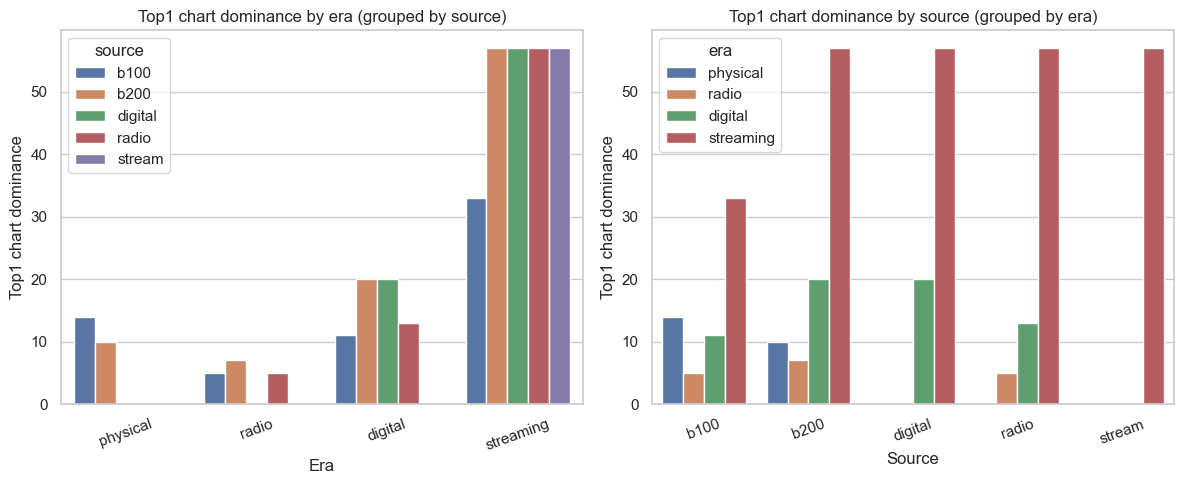

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# chart_dominance 对比图：同一时代的不同榜单 & 同一榜单的不同时代
if top_dom_df.empty:
    print('No chart_dominance data to plot')
else:
    # 排序 era，确保视觉顺序一致
    era_order = ['physical','radio','digital','streaming']
    if 'era' in top_dom_df.columns:
        top_dom_df['era'] = pd.Categorical(top_dom_df['era'], categories=era_order, ordered=True)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 不同榜单、同一 era 对比
    sns.barplot(data=top_dom_df, x='era', y='chart_dominance', hue='source', ax=axes[0])
    axes[0].set_title('Top1 chart dominance by era (grouped by source)')
    axes[0].set_xlabel('Era')
    axes[0].set_ylabel('Top1 chart dominance')
    axes[0].tick_params(axis='x', rotation=20)

    # 不同 era、同一榜单对比
    sns.barplot(data=top_dom_df, x='source', y='chart_dominance', hue='era', ax=axes[1])
    axes[1].set_title('Top1 chart dominance by source (grouped by era)')
    axes[1].set_xlabel('Source')
    axes[1].set_ylabel('Top1 chart dominance')
    axes[1].tick_params(axis='x', rotation=20)

    plt.tight_layout()
    plt.show()


/var/folders/8p/b5708bhd2pj92tqgr10m8cfh0000gn/T/ipykernel_70885/4028764499.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_dom = chart_df.groupby(['era','source'], as_index=False)['chart_dominance'].mean()


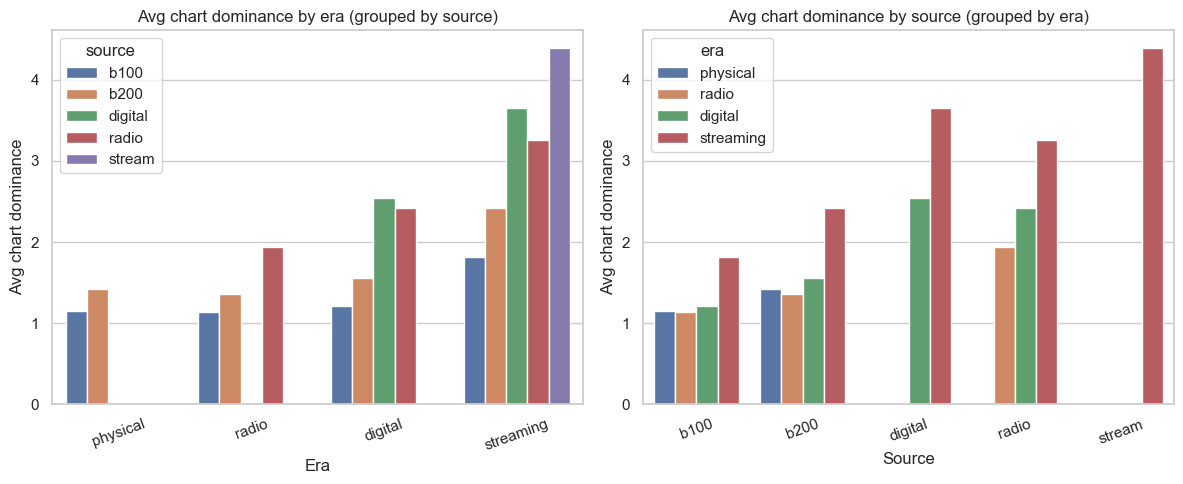

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# chart_dominance 对比图（均值）：同一时代的不同榜单 & 同一榜单的不同时代
if full_df.empty:
    print('No chart_dominance data to plot')
else:
    chart_df = full_df.copy()
    chart_df['chart_dominance'] = chart_df.groupby(['date','artist'])['song'].transform('count')
    # 过滤不需要的艺人
    exclude_artists = {'soundtrack', 'various artists'}
    chart_df = chart_df[~chart_df['artist'].str.lower().isin(exclude_artists)]

    era_order = ['physical','radio','digital','streaming']
    if 'era' in chart_df.columns:
        chart_df['era'] = pd.Categorical(chart_df['era'], categories=era_order, ordered=True)

    avg_dom = chart_df.groupby(['era','source'], as_index=False)['chart_dominance'].mean()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.barplot(data=avg_dom, x='era', y='chart_dominance', hue='source', ax=axes[0])
    axes[0].set_title('Avg chart dominance by era (grouped by source)')
    axes[0].set_xlabel('Era')
    axes[0].set_ylabel('Avg chart dominance')
    axes[0].tick_params(axis='x', rotation=20)

    sns.barplot(data=avg_dom, x='source', y='chart_dominance', hue='era', ax=axes[1])
    axes[1].set_title('Avg chart dominance by source (grouped by era)')
    axes[1].set_xlabel('Source')
    axes[1].set_ylabel('Avg chart dominance')
    axes[1].tick_params(axis='x', rotation=20)

    plt.tight_layout()
    plt.show()
